<a href="https://colab.research.google.com/github/CodeNelly-nelson/Finetunning_Medgemma4DR/blob/main/fine_tune_with_hugging_face_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Runtine informations

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jan 11 16:54:27 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   36C    P0             58W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

## Memory informations

In [ ]:
import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 179.4 gigabytes of available RAM

You are using a high-RAM runtime!


~~~
Copyright 2025 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
~~~

# Fine-tune MedGemma with Hugging Face

<table><tbody><tr>
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/google-health/medgemma/blob/main/notebooks/fine_tune_with_hugging_face.ipynb">
      <img alt="Google Colab logo" src="https://www.tensorflow.org/images/colab_logo_32px.png" width="32px"><br> Run in Google Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2Fgoogle-health%2Fmedgemma%2Fmain%2Fnotebooks%2Ffine_tune_with_hugging_face.ipynb">
      <img alt="Google Cloud Colab Enterprise logo" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" width="32px"><br> Run in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/google-health/medgemma/blob/main/notebooks/fine_tune_with_hugging_face.ipynb">
      <img alt="GitHub logo" src="https://github.githubassets.com/assets/GitHub-Mark-ea2971cee799.png" width="32px"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://huggingface.co/collections/google/medgemma-release-680aade845f90bec6a3f60c4">
      <img alt="Hugging Face logo" src="https://huggingface.co/front/assets/huggingface_logo-noborder.svg" width="32px"><br> View on Hugging Face
    </a>
  </td>
</tr></tbody></table>

This notebook demonstrates fine-tuning MedGemma on an image and text dataset for a vision task using Hugging Face libraries.

In this guide, you will use Hugging Face's [Transformer Reinforcement Learning (`TRL`)](https://github.com/huggingface/trl) library to train the model with Supervised Fine-Tuning (SFT), utilizing [Quantized Low-Rank Adaptation (QLoRA)](https://arxiv.org/abs/2305.14314) to reduce computational costs while maintaining high performance.


## Setup

To complete this tutorial, you'll need to have a runtime with sufficient resources to fine-tune the MedGemma model. **Note:** This guide requires a GPU that supports bfloat16 data type and has at least 40 GB of memory.

You can run this notebook in Google Colab using an A100 GPU:

1. In the upper-right of the Colab window, select **▾ (Additional connection options)**.
2. Select **Change runtime type**.
3. Under **Hardware accelerator**, select **A100 GPU**.

### Get access to MedGemma

Before you get started, make sure that you have access to MedGemma models on Hugging Face:

1. If you don't already have a Hugging Face account, you can create one for free by clicking [here](https://huggingface.co/join).
2. Head over to the [MedGemma model page](https://huggingface.co/google/medgemma-4b-it) and accept the usage conditions.

### Configure your HF token

Generate a Hugging Face `write` access token by going to [settings](https://huggingface.co/settings/tokens). **Note:** Make sure that the token has write access to push the fine-tuned model to Hugging Face Hub.

If you are using Google Colab, add your access token to the Colab Secrets manager to securely store it. If not, proceed to run the cell below to authenticate with Hugging Face.

1. Open your Google Colab notebook and click on the 🔑 Secrets tab in the left panel. <img src="https://storage.googleapis.com/generativeai-downloads/images/secrets.jpg" alt="The Secrets tab is found on the left panel." width=50%>
2. Create a new secret with the name `HF_TOKEN`.
3. Copy/paste your token key into the Value input box of `HF_TOKEN`.
4. Toggle the button on the left to allow notebook access to the secret.

In [ ]:
import os, sys
from huggingface_hub import get_token

if get_token() is None:
    from huggingface_hub import notebook_login
    notebook_login()

### Install dependencies

In [ ]:
!pip -q install --upgrade bitsandbytes datasets evaluate peft tensorboard transformers trl scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.3/512.3 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.0/557.0 kB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 145.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.9/518.9 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 151.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 57.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires tensorboard~=2.19.0, but you have tensorboard 2.20.0 which is incompatible.


## Prepare fine-tuning dataset


Load the data using the Hugging Face `datasets` library. Then, create train and validation splits.

In [ ]:
from datasets import load_dataset

DATASET_ID = "nelsonsoh8/eyepacs-dr-balanced-896"
data = load_dataset(DATASET_ID)

print(data)
print(data["train"].column_names)


README.md:   0%|          | 0.00/696 [00:00<?, ?B/s]

data/train-00000-of-00005.parquet:   0%|          | 0.00/429M [00:00<?, ?B/s]

data/train-00001-of-00005.parquet:   0%|          | 0.00/427M [00:00<?, ?B/s]

data/train-00002-of-00005.parquet:   0%|          | 0.00/429M [00:00<?, ?B/s]

data/train-00003-of-00005.parquet:   0%|          | 0.00/429M [00:00<?, ?B/s]

data/train-00004-of-00005.parquet:   0%|          | 0.00/427M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/267M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/269M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2832 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/354 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/354 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label_code', 'label'],
        num_rows: 2832
    })
    validation: Dataset({
        features: ['image', 'label_code', 'label'],
        num_rows: 354
    })
    test: Dataset({
        features: ['image', 'label_code', 'label'],
        num_rows: 354
    })
})
['image', 'label_code', 'label']


In [ ]:
label_col = "label_code"
print(sorted(set(data["train"][label_col])))


[0, 1, 2, 3, 4]


## See one image

Inspect a sample data point, which contains:

* `image`: image patch as a `PIL` image object
* `label_code`: integer class label corresponding to dr grade

In [ ]:
data["train"][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=896x896>,
 'label_code': 3,
 'label': 'severe_retinopathy'}

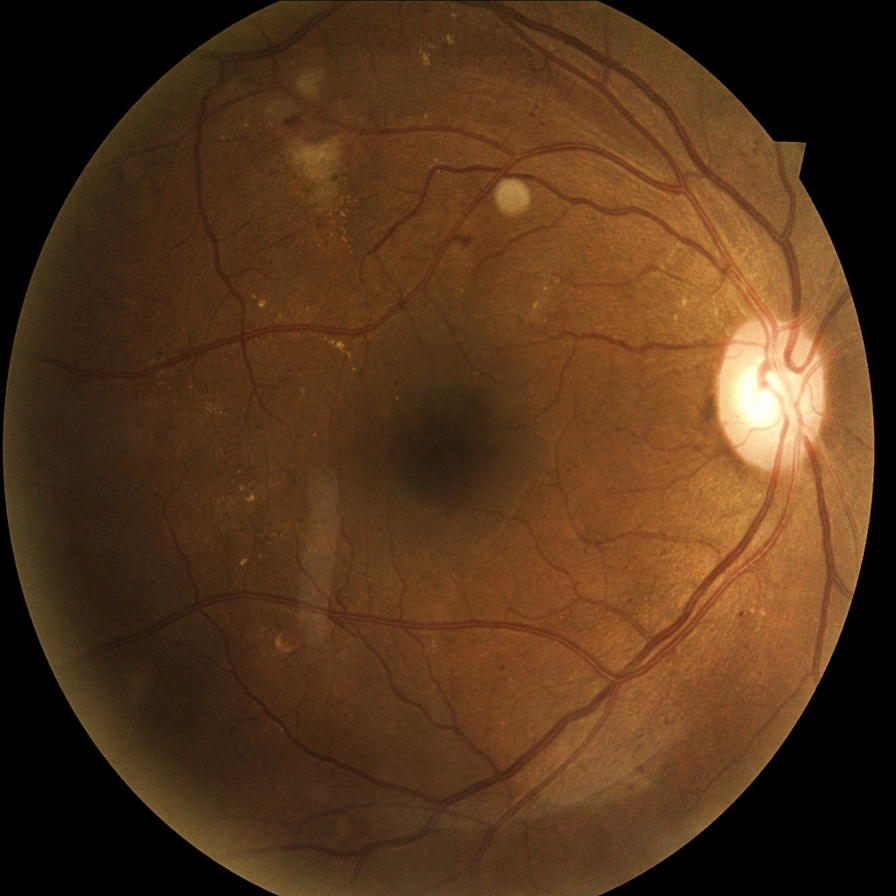

In [ ]:
data["train"][0]["image"]

In [ ]:
data["train"][0]["label_code"]

3

In [ ]:
data["train"][0]["label"]

'severe_retinopathy'

For this classification task, create a multiple-choice question prompt and preprocess the data into a multimodal conversational format.

In [ ]:
from typing import Any

DR_CLASSES = [
    "0: No diabetic retinopathy (grade 0)",
    "1: Mild diabetic retinopathy (grade 1)",
    "2: Moderate diabetic retinopathy (grade 2)",
    "3: Severe diabetic retinopathy (grade 3)",
    "4: Proliferative diabetic retinopathy (grade 4)",
]

OPTIONS = "\n".join(DR_CLASSES)

PROMPT = (
    "You are an expert ophthalmology assistant.\n"
    "What is the most likely diabetic retinopathy grade shown in this retinal fundus image?\n"
    "Choose the correct grade and respond with ONLY one digit: 0, 1, 2, 3, or 4.\n\n"
    f"{OPTIONS}"
)

label_col = "label_code"  # ensure this matches your dataset

def format_data(example: dict[str, Any]) -> dict[str, Any]:
    label_id = int(example[label_col])  # expected 0..4

    example["messages"] = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": PROMPT},
            ],
        },
        {
            "role": "assistant",
            "content": [
                {"type": "text", "text": str(label_id)},
            ],
        },
    ]
    return example


Apply the processing function on the dataset.

In [ ]:
data = data.map(format_data)

# Display a processed data sample
data["train"][0]

Map:   0%|          | 0/2832 [00:00<?, ? examples/s]

Map:   0%|          | 0/354 [00:00<?, ? examples/s]

Map:   0%|          | 0/354 [00:00<?, ? examples/s]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=896x896>,
 'label_code': 3,
 'label': 'severe_retinopathy',
 'messages': [{'content': [{'text': None, 'type': 'image'},
    {'text': 'You are an expert ophthalmology assistant.\nWhat is the most likely diabetic retinopathy grade shown in this retinal fundus image?\nChoose the correct grade and respond with ONLY one digit: 0, 1, 2, 3, or 4.\n\n0: No diabetic retinopathy (grade 0)\n1: Mild diabetic retinopathy (grade 1)\n2: Moderate diabetic retinopathy (grade 2)\n3: Severe diabetic retinopathy (grade 3)\n4: Proliferative diabetic retinopathy (grade 4)',
     'type': 'text'}],
   'role': 'user'},
  {'content': [{'text': '3', 'type': 'text'}], 'role': 'assistant'}]}

## Fine-tune the model with LoRA

Traditional fine-tuning of large language models is resource-intensive because it requires adjusting billions of parameters. Parameter-Efficient Fine-Tuning (PEFT) addresses this by training a smaller number of parameters. A common PEFT technique is Low-Rank Adaptation (LoRA), which efficiently adapts large language models by training small, low-rank matrices that are added to the original model instead of updating the full-weight matrices. In QLoRA, the base model is quantized to 4-bit before its weights are frozen, then LoRA adapter layers are attached and trained.

This notebook demonstrates supervised fine-tuning MedGemma with QLoRA using the `SFTTrainer` from the Hugging Face `TRL` library.

### Load model from Hugging Face Hub

Initialize the quantization configuration and load the model.

In [ ]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText, BitsAndBytesConfig

model_id = "google/medgemma-4b-it"

# MedGemma guide expects bf16-capable GPU (A100/H100 etc.)
if torch.cuda.is_available():
    major = torch.cuda.get_device_capability()[0]
    if major < 8:
        raise ValueError("GPU does not support bfloat16 (need Ampere+ like A100).")

model_kwargs = dict(
    attn_implementation="eager",
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

model_kwargs["quantization_config"] = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=model_kwargs["torch_dtype"],
    bnb_4bit_quant_storage=model_kwargs["torch_dtype"],
)

model = AutoModelForImageTextToText.from_pretrained(model_id, **model_kwargs)
processor = AutoProcessor.from_pretrained(model_id)
processor.tokenizer.padding_side = "right"


config.json:   0%|          | 0.00/2.47k [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

### Set up for fine-tuning

Create a [`LoraConfig`](https://huggingface.co/docs/peft/package_reference/lora#peft.LoraConfig). It will be provided to the `SFTTrainer`, which supports built-in integration with the Hugging Face `PEFT` library.

In [ ]:
from peft import LoraConfig

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=16,
    bias="none",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    task_type="CAUSAL_LM",
    modules_to_save=None,
)


Define a custom data collator that processes examples containing text and images and returns batches of data in the expected model input format.

In [ ]:
from typing import Any

def collate_fn(examples: list[dict[str, Any]]):
    texts = []
    images = []
    for ex in examples:
        images.append([ex["image"].convert("RGB")])
        texts.append(
            processor.apply_chat_template(
                ex["messages"], add_generation_prompt=False, tokenize=False
            ).strip()
        )

    batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

    labels = batch["input_ids"].clone()

    # mask pads + image tokens in loss
    boi_token = processor.tokenizer.special_tokens_map.get("boi_token", None)
    if boi_token is not None:
        boi_id = processor.tokenizer.convert_tokens_to_ids(boi_token)
        labels[labels == boi_id] = -100

    labels[labels == processor.tokenizer.pad_token_id] = -100

    # (medgemma notebook masks this constant too; keep it for safety)
    labels[labels == 262144] = -100

    batch["labels"] = labels
    return batch


Configure training parameters in an [`SFTConfig`](https://huggingface.co/docs/trl/sft_trainer#trl.SFTConfig).

In [ ]:
from trl import SFTConfig

num_train_epochs = 3  # @param {type: "number"}
learning_rate = 1e-4  # @param {type: "number"}

args = SFTConfig(
    output_dir="medgemma-eyepacs-dr-sft-qlora-run2",
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,

    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},

    optim="adamw_torch_fused",
    logging_steps=50,
    save_strategy="epoch",

    eval_strategy="steps",
    eval_steps=50,

    learning_rate=learning_rate,
    bf16=True,
    max_grad_norm=0.3,
    warmup_ratio=0.03,
    lr_scheduler_type="linear",

    push_to_hub=True,
    report_to="tensorboard",

    dataset_kwargs={"skip_prepare_dataset": True},
    remove_unused_columns=False,
    label_names=["labels"],
)



### Fine-tune the model

Construct an [`SFTTrainer`](https://huggingface.co/docs/trl/sft_trainer) using the previously defined LoRA configuration, custom data collator, and training parameters.

In [ ]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=data["train"],
    eval_dataset=data["validation"],
    peft_config=peft_config,
    processing_class=processor,
    data_collator=collate_fn,
)



In [ ]:
def print_trainable_params(model):
    trainable = 0
    total = 0
    for _, p in model.named_parameters():
        n = p.numel()
        total += n
        if p.requires_grad:
            trainable += n
    print(f"Trainable params: {trainable:,}")
    print(f"Total params:     {total:,}")
    print(f"Trainable %:      {100 * trainable / total:.4f}%")

print_trainable_params(trainer.model)



Trainable params: 11,898,880
Total params:     1,597,193,584
Trainable %:      0.7450%


Launch the fine-tuning process.

**Note**: This may take around 3 hours to run using the default configuration.

In [ ]:
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 1, 'bos_token_id': 2, 'pad_token_id': 0}.


Step,Training Loss,Validation Loss


Save the final model to Hugging Face Hub.

In [ ]:
trainer.save_model()

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...t-qlora/training_args.bin: 100%|##########| 6.35kB / 6.35kB            

  ...38128.556bba98fb32.1718.0: 100%|##########| 11.6kB / 11.6kB            

  ...sft-qlora/tokenizer.model: 100%|##########| 4.69MB / 4.69MB            

  ...-sft-qlora/tokenizer.json: 100%|##########| 33.4MB / 33.4MB            

  ...adapter_model.safetensors:  43%|####3     | 33.4MB / 77.1MB            

No files have been modified since last commit. Skipping to prevent empty commit.


Free up memory before proceeding to evaluate and test the fine-tuned model.

In [ ]:
import os, gc, torch

# Optional: helps fragmentation in long notebooks
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# If you still have trainer/model objects from training, delete them explicitly:
for name in ["trainer", "model", "ft_pipe", "pt_pipe"]:
    if name in globals():
        del globals()[name]

gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

print(torch.cuda.memory_summary(device=0, abbreviated=True))


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 3            |        cudaMalloc retries: 4         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   8220 MiB |  73157 MiB |   2525 TiB |   2525 TiB |
|---------------------------------------------------------------------------|
| Active memory         |   8220 MiB |  73157 MiB |   2525 TiB |   2525 TiB |
|---------------------------------------------------------------------------|
| Requested memory      |   8220 MiB |  73152 MiB |   2521 TiB |   2521 TiB |
|---------------------------------------------------------------

# Evaluate MedGemma on EyePACS DR (Baseline vs Fine-tuned)

In [ ]:
import re
import numpy as np
import torch
import evaluate
import matplotlib.pyplot as plt

from datasets import load_dataset
from sklearn.metrics import confusion_matrix, classification_report
from transformers import pipeline


# 1) Load test split

In [ ]:
DATASET_ID = "nelsonsoh8/eyepacs-dr-balanced-896"
LABEL_COL = "label_code"

data = load_dataset(DATASET_ID)
test_data = data["test"]

REFERENCES = [int(x) for x in test_data[LABEL_COL]]

print("Test samples:", len(test_data))
print("Unique labels:", sorted(set(REFERENCES)))

Test samples: 354
Unique labels: [0, 1, 2, 3, 4]


# 2) Metrics

In [ ]:
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(preds: list[int], refs: list[int]) -> dict[str, float]:
    metrics = {}
    metrics.update(accuracy_metric.compute(predictions=preds, references=refs))
    metrics.update(f1_metric.compute(predictions=preds, references=refs, average="weighted"))
    return metrics

# 3) Postprocessing: parse generated text -> class id


In [ ]:
def postprocess_generated_text(text: str) -> int:
    t = (text or "").strip()
    m = re.search(r"\b([0-4])\b", t)
    if m:
        return int(m.group(1))
    for i in range(5):
        if f"{i}:" in t:
            return i
    return -1

def extract_predictions(pipe_outputs) -> list[int]:
    preds = []
    for out in pipe_outputs:
        # pipeline usually returns list[dict] per sample
        if isinstance(out, list) and len(out) and isinstance(out[0], dict):
            gen_text = out[0].get("generated_text", "")
        elif isinstance(out, dict):
            gen_text = out.get("generated_text", "")
        else:
            gen_text = ""
        preds.append(postprocess_generated_text(gen_text))
    return preds

def filter_valid(preds: list[int], refs: list[int]):
    valid = [(p, r) for p, r in zip(preds, refs) if p != -1]
    if not valid:
        return [], [], 0.0
    preds_v = [p for p, _ in valid]
    refs_v  = [r for _, r in valid]
    return preds_v, refs_v, len(valid)/len(refs)


# 4) Build chat-text prompts that INCLUDE the image token


In [ ]:
# Important: We must build a text prompt that contains the image placeholder token,
# otherwise Gemma3 will throw: "Prompt contained 0 image tokens but received 1 images."

def build_text_with_image_token(prompt_text: str) -> str:
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": prompt_text},
            ],
        }
    ]
    # This will insert the model-specific image token into the final text
    return processor.apply_chat_template(
        messages,
        add_generation_prompt=True,
        tokenize=False
    )

# Create one chat-formatted text per sample
texts = [build_text_with_image_token(PROMPT) for _ in range(len(test_data))]

# Prepare images as PIL, and keep batch shape = list of lists (1 image per sample)
images = [[img.convert("RGB")] for img in test_data["image"]]



# 5) Baseline evaluation (pretrained MedGemma)

In [ ]:
processor.tokenizer.padding_side = "right"

pt_pipe = pipeline(
    "image-text-to-text",
    model=model_id,          # "google/medgemma-4b-it"
    processor=processor,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

pt_pipe.model.generation_config.do_sample = False
pt_pipe.model.generation_config.pad_token_id = processor.tokenizer.eos_token_id

pt_outputs = pt_pipe(
    text=texts,
    images=images,
    max_new_tokens=2,
    batch_size=8,
    return_full_text=False,
)

pt_preds = extract_predictions(pt_outputs)
pt_preds_v, refs_v, pt_coverage = filter_valid(pt_preds, REFERENCES)

pt_metrics = compute_metrics(pt_preds_v, refs_v) if pt_preds_v else {}
pt_metrics["coverage"] = pt_coverage

print("\n=== Baseline (pretrained) ===")
print("Coverage:", pt_coverage)
print(pt_metrics)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0



=== Baseline (pretrained) ===
Coverage: 1.0
{'accuracy': 0.5508474576271186, 'f1': 0.5262599632953399, 'coverage': 1.0}


# 6) Fine-tuned evaluation (your adapters/checkpoint)


In [ ]:
processor.tokenizer.padding_side = "left"

ft_pipe = pipeline(
    "image-text-to-text",
    model=args.output_dir,   # your fine-tuned output dir
    processor=processor,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

ft_pipe.model.generation_config.do_sample = False
ft_pipe.model.generation_config.pad_token_id = processor.tokenizer.eos_token_id

ft_outputs = ft_pipe(
    text=texts,
    images=images,
    max_new_tokens=2,
    batch_size=8,
    return_full_text=False,
)

ft_preds = extract_predictions(ft_outputs)
ft_preds_v, refs_v2, ft_coverage = filter_valid(ft_preds, REFERENCES)

ft_metrics = compute_metrics(ft_preds_v, refs_v2) if ft_preds_v else {}
ft_metrics["coverage"] = ft_coverage

print("\n=== Fine-tuned ===")
print("Coverage:", ft_coverage)
print(ft_metrics)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0



=== Fine-tuned ===
Coverage: 1.0
{'accuracy': 0.6214689265536724, 'f1': 0.6223261585481378, 'coverage': 1.0}


# 7) Confusion matrix + report (Fine-tuned)


Confusion Matrix (Fine-tuned) rows=true, cols=pred:
[[46 18  4  0  2]
 [22 37 12  0  0]
 [ 9  6 37 15  4]
 [ 1  0 15 51  4]
 [ 0  0  4 18 49]]

Classification Report (Fine-tuned):
              precision    recall  f1-score   support

           0     0.5897    0.6571    0.6216        70
           1     0.6066    0.5211    0.5606        71
           2     0.5139    0.5211    0.5175        71
           3     0.6071    0.7183    0.6581        71
           4     0.8305    0.6901    0.7538        71

    accuracy                         0.6215       354
   macro avg     0.6296    0.6216    0.6223       354
weighted avg     0.6297    0.6215    0.6223       354



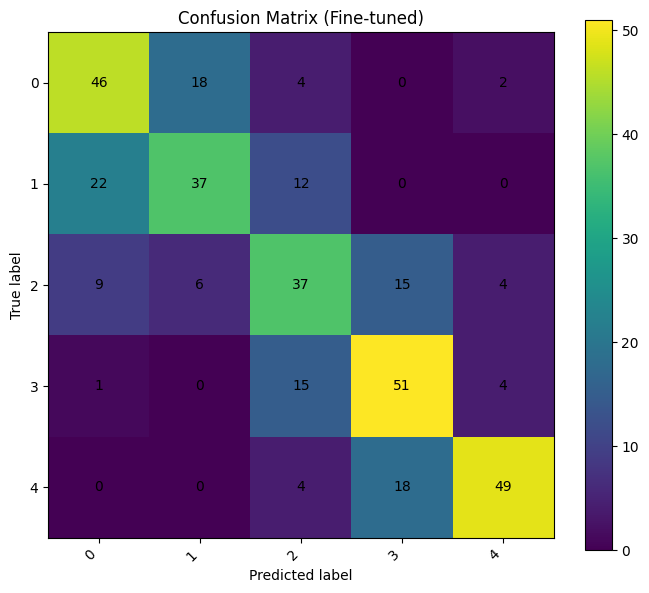

In [ ]:
def plot_confusion_matrix(cm, class_names, title="Confusion Matrix"):
    cm = np.array(cm)
    plt.figure(figsize=(7, 6))
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.xticks(np.arange(len(class_names)), class_names, rotation=45, ha="right")
    plt.yticks(np.arange(len(class_names)), class_names)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

if ft_preds_v:
    cm = confusion_matrix(refs_v2, ft_preds_v, labels=[0,1,2,3,4])
    print("\nConfusion Matrix (Fine-tuned) rows=true, cols=pred:")
    print(cm)

    print("\nClassification Report (Fine-tuned):")
    print(classification_report(refs_v2, ft_preds_v, labels=[0,1,2,3,4], digits=4))

    plot_confusion_matrix(cm, ["0","1","2","3","4"], title="Confusion Matrix (Fine-tuned)")
else:
    print("No valid predictions to compute confusion matrix (coverage=0).")


# 8) (Optional) Show a few raw generations to sanity-check

In [ ]:
print("\nSample fine-tuned generations:")
for i in range(5):
    out = ft_outputs[i]
    if isinstance(out, list) and len(out) > 0:
        print(i, "=>", out[0].get("generated_text", ""))
    elif isinstance(out, dict):
        print(i, "=>", out.get("generated_text", ""))
    else:
        print(i, "=>", out)



Sample fine-tuned generations:
0 => 4
1 => 0
2 => 0
3 => 2
4 => 3


In [ ]:
import os
from datetime import datetime

# -------------------------
# 1) Put your results here
# -------------------------
baseline_metrics = pt_metrics
finetuned_metrics = ft_metrics

conf_matrix = cm  # confusion matrix numpy array
class_report = classification_report(
    refs_v2, ft_preds_v, labels=[0, 1, 2, 3, 4], digits=4
)

# -------------------------
# 2) Create output filename
# -------------------------
run_stamp = datetime.now().strftime("%Y-%m-%d_%H%M%S")
out_dir = args.output_dir  # your run folder
os.makedirs(out_dir, exist_ok=True)

txt_path = os.path.join(out_dir, f"evaluation_results_{run_stamp}.txt")

# -------------------------
# 3) Write everything to txt
# -------------------------
with open(txt_path, "w") as f:
    f.write("===== MedGemma EyePACS DR Evaluation Results =====\n")
    f.write(f"Timestamp: {run_stamp}\n\n")

    f.write("----- Model Info -----\n")
    f.write(f"Base model: {model_id}\n")
    f.write(f"Fine-tuned model dir: {args.output_dir}\n")
    f.write(f"Dataset: {DATASET_ID}\n")
    f.write(f"Test samples: {len(test_data)}\n\n")

    f.write("----- Prompt -----\n")
    f.write(PROMPT + "\n\n")

    f.write("----- Baseline Metrics (Pretrained) -----\n")
    for k, v in baseline_metrics.items():
        f.write(f"{k}: {v}\n")
    f.write("\n")

    f.write("----- Fine-tuned Metrics -----\n")
    for k, v in finetuned_metrics.items():
        f.write(f"{k}: {v}\n")
    f.write("\n")

    f.write("----- Confusion Matrix (Fine-tuned) -----\n")
    f.write("Rows=True label, Cols=Pred label\n")
    f.write(str(conf_matrix) + "\n\n")

    f.write("----- Classification Report (Fine-tuned) -----\n")
    f.write(class_report + "\n\n")

print("✅ Saved evaluation results to:", txt_path)


In [ ]:
summary_path = os.path.join(out_dir, "best_run_summary.txt")

with open(summary_path, "w") as f:
    f.write(f"Baseline Acc: {pt_metrics['accuracy']:.4f}, F1: {pt_metrics['f1']:.4f}\n")
    f.write(f"Fine-tuned Acc: {ft_metrics['accuracy']:.4f}, F1: {ft_metrics['f1']:.4f}\n")

print("✅ Saved quick summary to:", summary_path)
